Images shape: (600, 256, 256, 3)
Masks shape: (600, 256, 256)


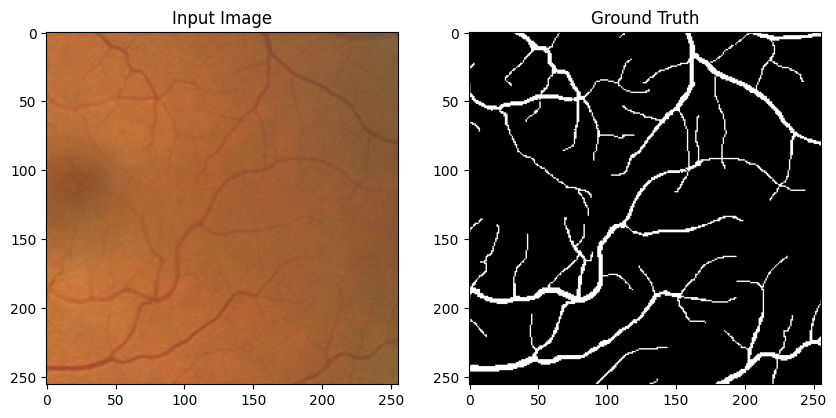

In [1]:
import os
import numpy as np
import cv2

# Define paths
image_dir = 'C:/Users/User/Desktop/Isengard/data2/img/train'
mask_dir = 'C:/Users/User/Desktop/Isengard/data2/seg/train'

# Load images and masks
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

images = []
masks = []

# Load and resize (if needed)
for img_file, mask_file in zip(image_files, mask_files):
    img = cv2.cvtColor(cv2.imread(os.path.join(image_dir, img_file)), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
    
    # Resize if necessary
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))
    
    # Normalize
    img = img / 255.0
    mask = mask / 255.0
    
    images.append(img)
    masks.append(mask)

# Convert to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

import matplotlib.pyplot as plt

# Visualize an input image, its mask, and the prediction
idx = 0
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(images[idx])

plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.imshow(masks[idx], cmap='gray')

plt.show()

# Example usage
X_train = images
Y_train = masks

Images shape: (160, 256, 256, 3)
Masks shape: (160, 256, 256)


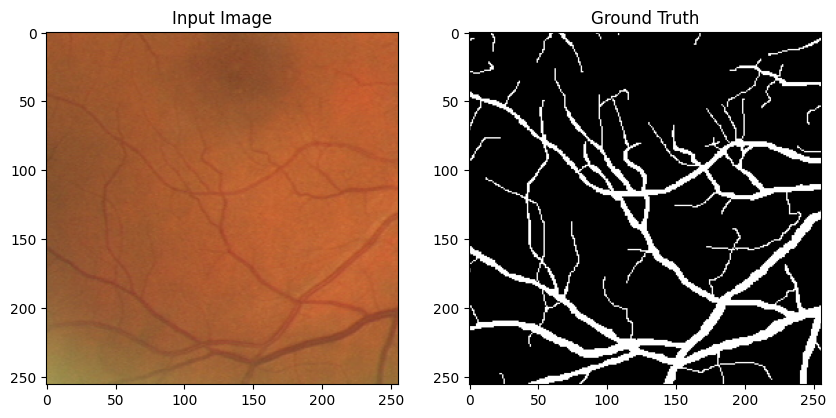

In [2]:
# Define paths
image_dir = 'C:/Users/User/Desktop/Isengard/data2/img/val'
mask_dir = 'C:/Users/User/Desktop/Isengard/data2/seg/val'

# Load images and masks
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

images = []
masks = []

# Load and resize (if needed)
for img_file, mask_file in zip(image_files, mask_files):
    img = cv2.cvtColor(cv2.imread(os.path.join(image_dir, img_file)), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
    
    # Resize if necessary
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))
    
    # Normalize
    img = img / 255.0
    mask = mask / 255.0
    
    images.append(img)
    masks.append(mask)

# Convert to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

import matplotlib.pyplot as plt

# Visualize an input image, its mask, and the prediction
idx = 0
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(images[idx])

plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.imshow(masks[idx], cmap='gray')

plt.show()

# Example usage
X_val = images
Y_val = masks

In [3]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

In [4]:
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
 
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
 
    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)
 
    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)
 
    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)
 
    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):

    # Inputs
    inputs = L.Input(input_shape)
 
    # Encoder: Contracting path
    c0, p0 = encoder_block(inputs, 32)
    c1, p1 = encoder_block(p0, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    # Bottleneck
    c5 = conv_block(p4, 1024)
 
    # Decoder: Expanding path
    u1 = decoder_block(c5, c4, 512)
    u2 = decoder_block(u1, c3, 256)
    u3 = decoder_block(u2, c2, 128)
    u4 = decoder_block(u3, c1, 64)
    u5 = decoder_block(u4, c0, 32)
 
    # Outputs
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(u5)
 
    # Model
    model = Model(inputs, outputs, name="Attention-Unet-retinal")

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

    return model

In [5]:
input_shape = (256, 256, 3)
metrics = [metrics.BinaryIoU(target_class_ids=(0, 1), threshold=0.5), metrics.Precision(), 'accuracy']
model = attention_unet(input_shape)
model.summary()

Model: "Attention-Unet-retinal"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 32,874,401 (125.41 MB)

 Trainable params: 32,858,401 (125.34 MB)

 Non-trainable params: 16,000 (62.50 KB)

In [6]:
history = model.fit(X_train, Y_train, 
                    validation_data=(X_val, Y_val),
                    batch_size=8,
                    epochs=50)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8082 - binary_io_u: 0.4808 - loss: 0.4821 - precision: 0.3170 - val_accuracy: 0.8784 - val_binary_io_u: 0.4392 - val_loss: 0.3863 - val_precision: 0.0000e+00
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9385 - binary_io_u: 0.7513 - loss: 0.1959 - precision: 0.8044 - val_accuracy: 0.8784 - val_binary_io_u: 0.4392 - val_loss: 0.3831 - val_precision: 0.3333
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9454 - binary_io_u: 0.7785 - loss: 0.1605 - precision: 0.8323 - val_accuracy: 0.8780 - val_binary_io_u: 0.4392 - val_loss: 0.4511 - val_precision: 0.1100
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9469 - binary_io_u: 0.7820 - loss: 0.1493 - precision: 0.8323 - val_accuracy: 0.8794 - val_binary_io_u: 0.4637 - val_loss: 0.3858 - val_precision: 0.5444
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9489 - binary_io_u: 0.7910 - loss: 0.1393 - precision: 

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
iou = history.history['binary_io_u']
val_iou = history.history['val_binary_io_u']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

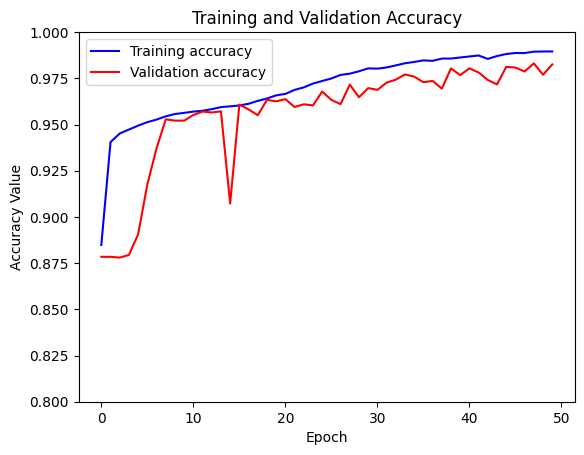

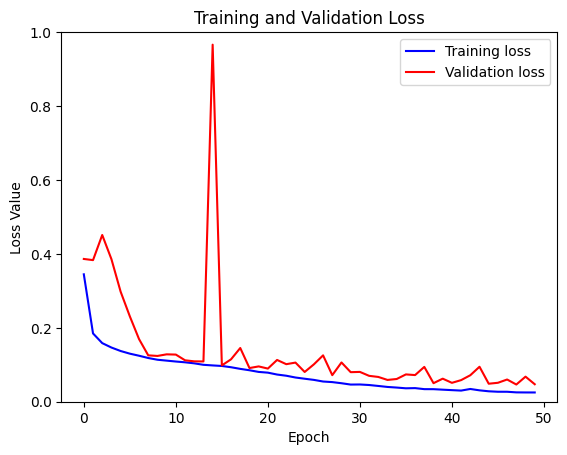

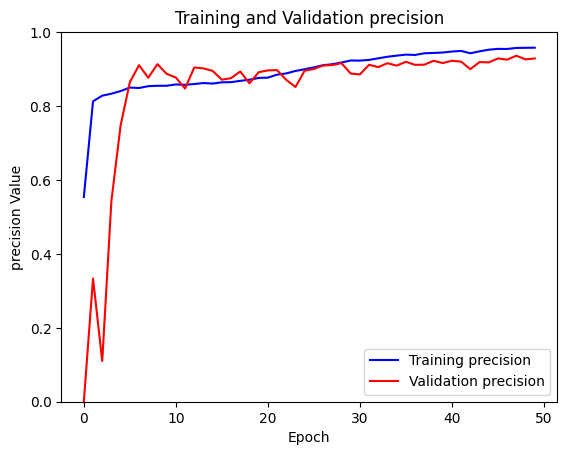

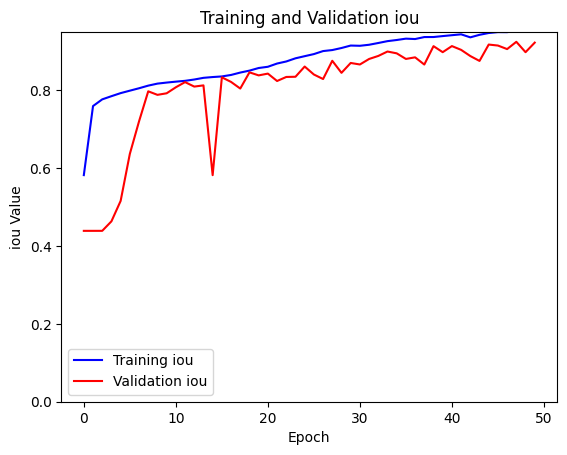

In [8]:
plt.figure()
plt.plot(history.epoch, accuracy, 'b', label='Training accuracy')
plt.plot(history.epoch, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0.8, 1])
plt.legend()
plt.show()

plt.figure()
plt.plot(history.epoch, loss, 'b', label='Training loss')
plt.plot(history.epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


plt.figure()
plt.plot(history.epoch, precision, 'b', label='Training precision')
plt.plot(history.epoch, val_precision, 'r', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


plt.figure()
plt.plot(history.epoch, iou, 'b', label='Training iou')
plt.plot(history.epoch, val_iou, 'r', label='Validation iou')
plt.title('Training and Validation iou')
plt.xlabel('Epoch')
plt.ylabel('iou Value')
plt.ylim([0, 0.95])
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
(256, 256, 3) (256, 256)


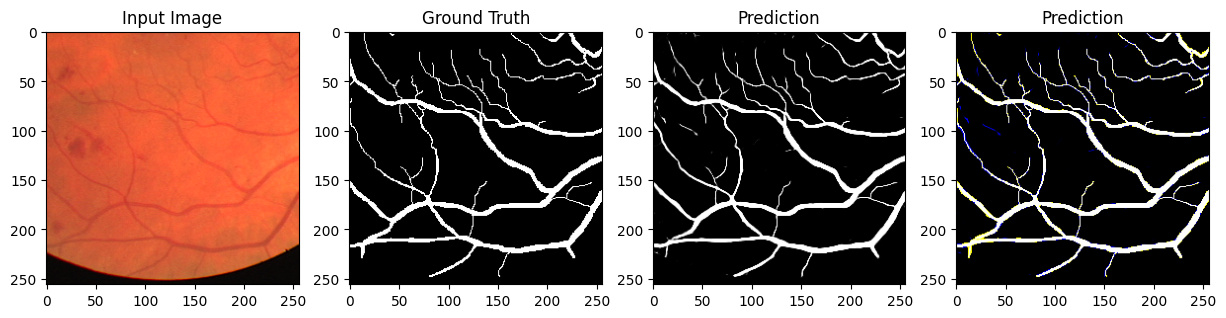

In [62]:
# Define paths
image_dir = 'C:/Users/User/Desktop/Isengard/data2/img/test'
mask_dir = 'C:/Users/User/Desktop/Isengard/data2/seg/test'

# Load images and masks
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

images = []
masks = []

# Load and resize (if needed)
for img_file, mask_file in zip(image_files, mask_files):
    img = img = cv2.cvtColor(cv2.imread(os.path.join(image_dir, img_file)), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
    
    # Resize if necessary
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))
    
    # Normalize
    img = img / 255.0
    mask = mask / 255.0
    
    images.append(img)
    masks.append(mask)

# Convert to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

# Example usage
X_test = images
Y_test = masks

# Make predictions
idx = 10  # Index of the test sample
pred = model.predict(np.expand_dims(X_test[idx], axis=0))

#img_diff = pred.squeeze()-Y_test[idx].squeeze()

gt = Y_test[idx].squeeze()
predicted = pred.squeeze()

diff = np.zeros(gt.shape+(3,))
print(diff.shape, gt.shape)

diff[:, :, 0] = gt
diff[:, :, 1] = gt
diff[:, :, 2] = predicted

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.title("Input Image")
plt.imshow(X_test[idx])

plt.subplot(1, 4, 2)
plt.title("Ground Truth")
plt.imshow(gt, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Prediction")
plt.imshow(predicted, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Prediction")
#plt.imshow(img_diff, cmap='afmhot')
plt.imshow(diff)
plt.show()

In [43]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

In [42]:
dice=[]

for i in range(len(Y_test)):
    pred = model.predict(np.expand_dims(X_test[i], axis=0))
    dc=DICE_COE(pred.squeeze(),Y_test[i].squeeze())
    dice.append(dc)

print(np.mean(dice))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━